In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2 as cv
import os
from IPython.display import clear_output

from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
from astropy.table import Table
from tqdm import tqdm

import numpy as np

In [2]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
fits_folder = 'E:/cosmos-fits'
cosmos_folder = 'E:/cosmos-data'

In [19]:
df_cat = pd.read_csv(f'{combine_fold}/cosmos2020-categorised-interactions.csv', index_col = 0)

In [4]:
df_red_tmp = df_cat.query('ez_sfr < 10')
df_red = df_red_tmp.query('lp_mass_best > 6.5')

In [15]:
df_clsf = pd.read_csv(f'{combine_fold}/correcting-stage1.csv', index_col = 0).rename(columns = {"0" : 'pred'})

In [7]:
with fits.open(f'{cosmos_folder}/COSMOS2020_CLASSIC_R1_v2.1_p3.fits.gz') as hdul:
    data = hdul[1].data

In [16]:
df_clsf

,ORyan23_ID,pred
0,4000705533383,stage2
1,4000705539529,stage4
2,4000705540034,stage3
3,4000705546924,nm
4,4000707045688,b
...,...,...
376,6000534268229,nm
377,6000534268401,stage3
378,6000535781491,b
379,6000536013240,b


In [17]:
df_redo = df_clsf.query('pred != "nm"')

In [21]:
df_redo.pred.value_counts()

stage2          93
sec_present     80
b               76
stage4          31
stage1          21
stage3          17
sec_present]     1
Name: pred, dtype: int64

In [14]:
def picking_z(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

In [15]:
def getting_secondary(ra, dec, z, prim_id):
    record = data[(data['ALPHA_J2000'] > ra - (15 / (60*60))) & (data['ALPHA_J2000'] < ra + (15 / (60*60))) & (data['DELTA_J2000'] > dec - (15 / (60*60))) & (data['DELTA_J2000'] < dec + (15 / (60*60)))]
    
    df = Table(record).to_pandas()[['ID', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST']]
    
    df_z = (
        df
        .assign(redshift = df.apply(lambda row: picking_z(row.ez_z_phot, row.lp_zBEST), axis = 1))
        .drop(columns = ['ez_z_phot', 'lp_zBEST'])
        .dropna()
        .query('ID != @prim_id')
    )   
    
    return df_z

In [24]:
cat_dict = {}

In [29]:
def picking_z(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

In [30]:
def getting_secondary(ra, dec, z, prim_id):
    record = data[(data['ALPHA_J2000'] > ra - (15 / (60*60))) & (data['ALPHA_J2000'] < ra + (15 / (60*60))) & (data['DELTA_J2000'] > dec - (15 / (60*60))) & (data['DELTA_J2000'] < dec + (15 / (60*60)))]
    
    df = Table(record).to_pandas()[['ID', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST']]
    
    df_z = (
        df
        .assign(redshift = df.apply(lambda row: picking_z(row.ez_z_phot, row.lp_zBEST), axis = 1))
        .drop(columns = ['ez_z_phot', 'lp_zBEST'])
        .dropna()
        .query('ID != @prim_id')
    )   
    
    return df_z

 56%|█████▌    | 179/319 [04:38<30:56, 13.26s/it]C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log10


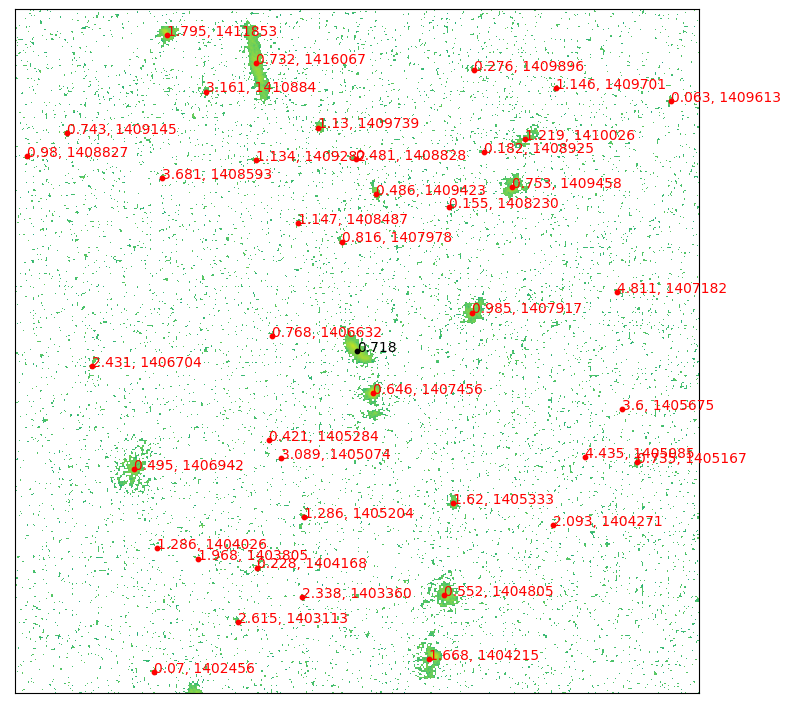

Previous Classifications: sec_present 


 56%|█████▌    | 179/319 [04:54<03:50,  1.64s/it]


KeyboardInterrupt: Interrupted by user

In [37]:
for i in tqdm(range(len(df_redo))):
    
    sourceid = df_redo.ORyan23_ID.iloc[i]
    if sourceid in list(cat_dict.keys()):
        continue
    
    fig, ax = plt.subplots(figsize = (8,8))
    file_path = f'{fits_folder}/{sourceid}.fits'
    assert os.path.exists(file_path)

    ra = df_red.query('ORyan23_ID == @sourceid')['ALPHA_J2000'].iloc[0]
    dec = df_red.query('ORyan23_ID == @sourceid')['DELTA_J2000'].iloc[0]
    z_ez = df_red.query('ORyan23_ID == @sourceid')['ez_z_phot'].iloc[0]
    z_lp = df_red.query('ORyan23_ID == @sourceid')['lp_zBEST'].iloc[0]
    id_str = df_red.query('ORyan23_ID == @sourceid')['ID'].iloc[0]
    category = df_redo.query('ORyan23_ID == @sourceid')['pred'].iloc[0]
    
    if category == 'nm':
        continue

    redshift = picking_z(z_ez, z_lp)

    prim_coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'fk5')

    df_secs = getting_secondary(ra, dec, redshift, id_str)

    with fits.open(file_path) as hdul:
        im_data = hdul[0].data
        header = hdul[0].header

    w = WCS(header)

    df_coords = (
        df_secs
        .assign(coords = df_secs.apply(lambda row: SkyCoord(ra = row.ALPHA_J2000 * u.deg, dec = row.DELTA_J2000 * u.deg, frame = 'fk5'), axis = 1))
    )

    id_list = list(df_coords.ID)
    coords_list = list(df_coords.coords)
    z_list = list(df_coords.redshift)

    pixs_list = []
    for j in coords_list:
        pixs_list.append(skycoord_to_pixel(j, w, origin = 0))
    pixs_arr = np.array(pixs_list)

    prim_pix = np.array(skycoord_to_pixel(prim_coord, w, origin = 0))

    ax.imshow(np.log10(im_data), origin = 'lower')
    ax.scatter(prim_pix[0], prim_pix[1], s = 10, color='black')
    ax.annotate(np.round(redshift, 3), (prim_pix[0], prim_pix[1]), color = 'black')
    ax.scatter(pixs_arr[:,0], pixs_arr[:,1], s = 10, color = 'red')
    for i, txt in enumerate(z_list):
        ax.annotate(f'{np.round(txt, 3)}, {id_list[i]}', (pixs_arr[i,0], pixs_arr[i,1]), color = 'red')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()
    plt.show()
    
    print(f'Previous Classifications: {category} ')
    if category == 'b':
        prim_id = input('Please provide new primary ID.')
        sec_id = input('Provide ID of secondary.')
        stage = input('Please provide the stage.')
    elif category == 'sec_present':
        prim_id = id_str
        sec_id = input('Please provide ID of the secondary.')
        stage = input('Please provide the stage.')
    elif 'stage' in category:
        prim_id = id_str
        sec_id = np.nan
        stage = category
    
    cat_dict[sourceid] = {'prim_id': prim_id, 'sec_id': sec_id, 'category' : stage}
             
    plt.close()
    clear_output(wait = True)

In [38]:
df_restage = pd.DataFrame.from_dict(cat_dict, orient = 'index').reset_index().rename(columns = {'index' : 'ORyan23_ID', '0' : 'corr_stage'})

In [ ]:
df_resage.to_csv('')

In [ ]:
done_ids = list(secondaries.keys())
for i in tqdm(list(sec_df.SourceID)):
    id_2020 = sec_df.query('SourceID == @i').sec_id.iloc[0]
    secondaries[i] = get_data(id_2020)

### Removing Checked IDs from Path

### Saving New Stage1 Fixed